# Exploratory Data Analysis for Final Project

In this assignment, your task is to put your new skils to use in the form of an open-ended, exploratory data analysis. In particular, I'm looking for you to demonstrate your ability to use the programmatic tools we've been learning to access data, manipulate it, and visualize some findings while working towards the ultimate goal of developing a final project proposal. Please include the following in your assignment:

  1. A brief summary of the topic (a few sentences)
  2. Access 2 or more datasets, at least one of them using an API (if you are not using any data from an API as part of your project yet, don’t worry about it, and just do this to get some exercise using APIs. You might use it later).
  3. Demonstrate the use of Pandas operations to filter out missing data and/or outliers.
  4. Demonstrate your capacity to use some of the "group-by" operations to produce pivot tables or statistical summaries of your data.
  5. Use Matplotlib or Seaborn to produce 2-3 data visualizations of your data to both explore the data and highlight any notable patterns.
  6. Include a short written analysis of your interpretation of the data.
  7. In a few paragraphs, describe the research question you intend to investigate in your final project, and the plan for the data analysis you intend to perform.

Note that this exercise is intended to help you formulate your project topic. But it is not a binding contract. Your project will most likely evolve over the rest of the semester. So use this as an opportunity to be creative, throw some ideas against the wall and see what sticks. I will release the final project guidelines shortly. In the meantime, dig in!

And as always, please submit this assignment both as a PR on GitHub along with the URL of your PR on bCourses.

I am interested in exploring the kinds of facilities (walking and transit) are in proximity of the pipeline of affordable housing projects in Los Angeles. I would like to incorporate LA Metro GTFS data to add bus and train routes. I am mostly basing my projects around the LAHD Affordable Housing Project List and seeing what data can be tied to the area surrounding the sites. Through the data I am curious to see the trends, are projects mostly in census tracts with high transportation access? Are they in already dense areas?
The current data sets are the:
2021 Walk and Bike Counts https://data.lacity.org/dataset/2021-Walk-Bike-Count/9tzi-nz7g/about_data
LAHD Affordable Housing Project List https://data.lacity.org/Housing-and-Real-Estate/LAHD-Affordable-Housing-Projects-List-2003-to-Pres/mymu-zi3s/about_data
Transportation Index https://geohub.lacity.org/datasets/lahub::transportation-index/about
Vision Zero Prioritized Corridors https://geohub.lacity.org/datasets/ladot::vision-zero-prioritized-corridors/about


In [1]:
import pandas as pd
import json    
import requests
import pprint
import numpy as np
pp = pprint.PrettyPrinter
!pip install geopandas
import geopandas as gpd
pd.set_option('display.max_columns', None)
!pip install contextily
import contextily as cx
from scipy.stats import pearsonr
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import os
from mapboxgl.utils import *
from mapboxgl.viz import *
from census import Census
from us import states

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor ### VIF package
from stargazer.stargazer import Stargazer

import warnings; warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'stargazer'

In [2]:
with open(r"C:\Users\sandr\UCB_CYPLAN255_2024\notebooks\data\mapbox_api_key.json", 'r') as f:
    token = json.load(f)['key']

with open(r"C:\Users\sandr\UCB_CYPLAN255_2024\notebooks\data\census_api_key.json", 'r') as f:
    c = json.load(f)['key']

In [3]:
lawalk_endpoint_url = "https://data.lacity.org/resource/9tzi-nz7g.json"
response = requests.get(lawalk_endpoint_url)
print(response.text[:500])


[{"_2023_index":"23-1","street_name":"1st St","limit_1":"Central Ave","limit_2":"San Pedro St","full_name":"1st St bw Central Ave & San Pedro St","facility_type":"Lane","ped_total":"2455","ped_female":"1030","ped_male":"1425","ped_mobassist":"14","ped_stroller":"1","ped_weekday":"985","ped_weekday_female":"396","ped_weekday_male":"589","ped_weekday_mobassist":"14","ped_weekday_stroller":"1","ped_weekend":"1470","ped_weekend_female":"634","ped_weekend_male":"836","ped_weekend_mobassist":"0","ped_


In [4]:
walk_counts = pd.read_json(lawalk_endpoint_url)
walk_counts.head()

,_2023_index,street_name,limit_1,limit_2,full_name,facility_type,ped_total,ped_female,ped_male,ped_mobassist,ped_stroller,ped_weekday,ped_weekday_female,ped_weekday_male,ped_weekday_mobassist,ped_weekday_stroller,ped_weekend,ped_weekend_female,ped_weekend_male,ped_weekend_mobassist,ped_weekend_stroller,bike_total,bike_female,bike_male,bike_sidewalk,bike_contraflow,bike_bikeshare,bike_helmet,bike_weekday_total,bike_weekday_female,bike_weekday_male,bike_weekday_sidewalk,bike_weekday_contraflow,bike_weekday_bike_weekdayshare,bike_weekday_helmet,bike_weekend_total,bike_weekend_female,bike_weekend_male,bike_weekend_sidewalk,bike_weekend_contraflow,bike_weekend_bike_weekendshare,bike_weekend_helmet,scooter_total,scooter_female,scooter_male,scooter_sidewalk,scooter_contraflow,scooter_helmet,scooter_weekday_total,scooter_weekday_female,scooter_weekday_male,scooter_weekday_sidewalk,scooter_weekday_contraflow,scooter_weekday_helmet,scooter_weekend_total,scooter_weekend_female,scooter_weekend_male,scooter_weekend_sidewalk,scooter_weekend_contraflow,scooter_weekend_helmet,other_total,other_female,other_male,other_sidewalk,other_contraflow,other_helmet,other_weekday_total,other_weekday_female,other_weekday_male,other_weekday_sidewalk,other_weekday_contraflow,other_weekday_helmet,other_weekend_total,other_weekend_female,other_weekend_male,other_weekend_sidewalk,other_weekend_contraflow,other_weekend_helmet
0,23-1,1st St,Central Ave,San Pedro St,1st St bw Central Ave & San Pedro St,Lane,2455,1030,1425,14,1,985.0,396.0,589.0,14.0,1.0,1470.0,634.0,836.0,0.0,0.0,249,21,228,21,6,1,24,64.0,3.0,61.0,21.0,3.0,1.0,16.0,185.0,18.0,167.0,0.0,3.0,0.0,8.0,21,3,18,6,0,7,18.0,2.0,16.0,6.0,0.0,7.0,3.0,1.0,2.0,0.0,0.0,0.0,24,4,20,15,1,9,17.0,4.0,13.0,10.0,1.0,9.0,7,0.0,7.0,5.0,0.0,0.0
1,23-2,1st St,Soto St,Mathews St,1st St bw Soto St & Mathews St,Lane,184,36,148,7,2,NaN,NaN,NaN,NaN,NaN,184.0,36.0,148.0,7.0,2.0,13,0,13,4,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,0.0,13.0,4.0,0.0,0.0,1.0,4,0,4,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,4.0,4.0,0.0,4.0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,0.0
2,23-3,4th St,Rossmore Ave,Arden Blvd,4th St bw Rossmore Ave & Arden Blvd,Sharrow,354,195,159,0,6,267.0,150.0,117.0,0.0,3.0,87.0,45.0,42.0,0.0,3.0,106,30,76,2,1,0,65,79.0,19.0,60.0,1.0,1.0,0.0,48.0,27.0,11.0,16.0,1.0,0.0,0.0,17.0,34,6,28,1,1,15,22.0,3.0,19.0,1.0,1.0,9.0,12.0,3.0,9.0,0.0,0.0,6.0,3,0,3,0,0,0,3.0,0.0,3.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
3,23-4,54th St,Gramercy Pl,Ruthelen St,54th St bw Gramercy Pl & Ruthelen St,Lane,185,71,114,2,1,154.0,60.0,94.0,2.0,1.0,31.0,11.0,20.0,0.0,0.0,28,0,28,12,3,0,5,25.0,0.0,25.0,12.0,2.0,0.0,5.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,4,0,4,3,0,2,2.0,0.0,2.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,6,0,6,5,1,0,4.0,0.0,4.0,4.0,0.0,0.0,2,0.0,2.0,1.0,1.0,0.0
4,23-5,5th St,Main St,Spring St,5th St bw Main St & Spring St,Protected Lane,2810,807,2003,68,20,2030.0,506.0,1524.0,53.0,13.0,780.0,301.0,479.0,15.0,7.0,231,5,226,63,52,0,21,168.0,5.0,163.0,40.0,36.0,0.0,16.0,63.0,0.0,63.0,23.0,16.0,0.0,5.0,85,10,75,28,21,0,69.0,10.0,59.0,22.0,16.0,0.0,16.0,0.0,16.0,6.0,5.0,0.0,22,1,21,13,4,1,16.0,0.0,16.0,9.0,3.0,0.0,6,1.0,5.0,4.0,1.0,1.0


In [5]:
walk_counts.columns

Index(['_2023_index', 'street_name', 'limit_1', 'limit_2', 'full_name',
       'facility_type', 'ped_total', 'ped_female', 'ped_male', 'ped_mobassist',
       'ped_stroller', 'ped_weekday', 'ped_weekday_female', 'ped_weekday_male',
       'ped_weekday_mobassist', 'ped_weekday_stroller', 'ped_weekend',
       'ped_weekend_female', 'ped_weekend_male', 'ped_weekend_mobassist',
       'ped_weekend_stroller', 'bike_total', 'bike_female', 'bike_male',
       'bike_sidewalk', 'bike_contraflow', 'bike_bikeshare', 'bike_helmet',
       'bike_weekday_total', 'bike_weekday_female', 'bike_weekday_male',
       'bike_weekday_sidewalk', 'bike_weekday_contraflow',
       'bike_weekday_bike_weekdayshare', 'bike_weekday_helmet',
       'bike_weekend_total', 'bike_weekend_female', 'bike_weekend_male',
       'bike_weekend_sidewalk', 'bike_weekend_contraflow',
       'bike_weekend_bike_weekendshare', 'bike_weekend_helmet',
       'scooter_total', 'scooter_female', 'scooter_male', 'scooter_sidewalk',
    

In [6]:
#group by facility type, review lowest ped counts
#I want to geocode the count intersections

In [7]:
ft_totals = walk_counts[['facility_type', 'ped_total','ped_female','ped_male','ped_mobassist']].groupby('facility_type').sum()
ft_totals

,ped_total,ped_female,ped_male,ped_mobassist
facility_type,,,,
Buffered Lane,1124,425,699,7
Lane,19533,8519,11014,95
None,43256,17925,25331,279
Path,2056,799,1257,7
Protected Lane,26884,9498,17386,263
Route,1768,834,934,8
Sharrow,1952,819,1133,5


In [8]:
st_totals = walk_counts[['street_name', 'ped_total','ped_female','ped_male','ped_mobassist']].groupby('street_name').sum()
st_totals

,ped_total,ped_female,ped_male,ped_mobassist
street_name,,,,
1st St,2639,1066,1573,21
4th St,354,195,159,0
54th St,185,71,114,2
5th St,2810,807,2003,68
6th St,2305,748,1557,43
...,...,...,...,...
Wilmington Ave,226,96,130,5
Wilshire Blvd,1417,551,866,4
Winnetka Ave,12,5,7,0


In [9]:
la_tindex_endpoint_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/Transportation_Index/FeatureServer/99/query?outFields=*&where=1%3D1&f=geojson"
response = requests.get(la_tindex_endpoint_url)
print(response.text[:1000])

{"type":"FeatureCollection","features":[{"type":"Feature","id":1,"geometry":{"type":"Polygon","coordinates":[[[-118.297931242481,34.2632272511851],[-118.297914063364,34.2632269364517],[-118.296972481548,34.2632211981564],[-118.296031297275,34.2632154515662],[-118.295681227894,34.2632133121419],[-118.295154850125,34.2632100897881],[-118.29435058916,34.2632051781571],[-118.294203823936,34.2628910400769],[-118.29330595072,34.2628808532104],[-118.292313419236,34.2628698163477],[-118.29132088696,34.2628584693365],[-118.29008475398,34.2628438783159],[-118.288479219454,34.2628249076181],[-118.287640326168,34.2628150881203],[-118.286817584542,34.2628051686517],[-118.286498556957,34.2628014722563],[-118.285753978282,34.2626434431704],[-118.284925706476,34.262467552388],[-118.284922471315,34.261781689132],[-118.284911548953,34.2594836341982],[-118.284939939569,34.2582704595097],[-118.284946422491,34.2579787574021],[-118.284973151806,34.2567738031694],[-118.284992652559,34.2558941331282],[-118.28

In [10]:
gpd.read_file(la_tindex_endpoint_url).head()

,OBJECTID,TRACT00,TRACT,Total_Pop,Sq_Mi,PopSqMi,WLK,BK,WLKnBK,WLKnBK_SS_Rev,WLKnBK_SS,Metro,Metro_SS_Rev,Metro_SS,INTRSC_D,INTRSC_D_SS_Rev,INTRSC_D_SS,BK_LN_Mi,BK_LN_Mi_SS_Rev,BK_LN_Mi_SS,MTS,MTS_SS_Rev,MTS_SS,MV_BIKE_HIT,MV_PED_HIT,MV_BP_HIT_10k,MV_BP_HIT_10k_SS,MV_PD_Un18,MV_PD_Un18_10k,MV_PD_Un18_10k_SS,INDEX_SCORE,Shape__Area,Shape__Length,geometry
0,1,101110,101110,4283.0,0.441083,9710.0,0.0,0.0,0.0,100.000000,0.000000,23.0,99.983814,0.016186,172.3199,73.241903,26.758097,0.248081,95.973780,4.026220,0,100.0,0.0,2,10,28.017745,0.777322,7,16.343684,4.797662,67.824926,1.229550e+07,15083.490095,"POLYGON ((-118.29793 34.26323, -118.29791 34.2..."
1,2,101122,101122,3405.0,1.020866,3335.0,0.5,0.0,0.5,99.312242,0.687758,NaN,NaN,NaN,120.4830,81.291216,18.708784,0.000000,100.000000,0.000000,0,100.0,0.0,0,3,8.810573,0.244440,1,2.936858,0.862110,68.815715,2.637831e+07,30895.536646,"POLYGON ((-118.29101 34.27478, -118.29114 34.2..."
2,3,101210,101210,6347.0,0.251232,25263.0,2.4,0.0,2.4,96.698762,3.301238,138.0,99.902887,0.097113,207.0154,67.854332,32.145668,0.946569,84.637700,15.362300,0,100.0,0.0,4,20,37.813140,1.049084,5,7.877738,2.312497,64.636466,7.002749e+06,12066.880686,"POLYGON ((-118.28594 34.25590, -118.28594 34.2..."
3,4,101220,101220,3702.0,0.269871,13718.0,0.5,0.0,0.5,99.312242,0.687758,203.0,99.857145,0.142855,226.0399,64.900179,35.099821,0.916225,85.130165,14.869835,0,100.0,0.0,3,8,29.713668,0.824373,2,5.402485,1.585891,64.515714,7.523373e+06,12697.819097,"POLYGON ((-118.27818 34.25577, -118.27824 34.2..."
4,5,101300,101300,3884.0,0.996294,3898.0,0.0,0.0,0.0,100.000000,0.000000,195.0,99.862775,0.137225,122.5726,80.966739,19.033261,1.019603,83.452394,16.547606,0,100.0,0.0,4,13,43.769310,1.214331,2,5.149331,1.511578,66.715402,2.774817e+07,29295.933607,"POLYGON ((-118.27531 34.25990, -118.27408 34.2..."


#Have trouble locating the codebook for this index: The Transportation Index was developed to compare conditions of one place to another. The Index standardizes transportation demand, transportation infrastructure, and injury variables, and then averages them together, yielding a score on a scale of 0-100. Higher values indicate worse transportation conditions. Variables include: percent walk and bike to work (2019 5-Year ACS), transit riders (2019 Metro), transit service frequency (2019 Metro), bicycle infrastructure (2021 LADOT), intersection density (2019 City of Los Angeles Department of City Planning), and bike and pedestrian injuries per 10,000 (2020 Statewide Integrated Traffic Records System). Data were classified using the quantile method.

In [11]:
transpo_index = gpd.read_file(la_tindex_endpoint_url)
transpo_index.columns
#compare PopSqMi to Metro, BK_LN_Mi, MV_BP_HIT_10k, Intersection Density
#what tracts have highest PopSqMi to Metro, BK_LN_Mi, MV_BP_HIT_10k, Intersection Density, can we make that a chloropleth?
#see what outliers have low pop but hight HIT or high index score

Index(['OBJECTID', 'TRACT00', 'TRACT', 'Total_Pop', 'Sq_Mi', 'PopSqMi', 'WLK',
       'BK', 'WLKnBK', 'WLKnBK_SS_Rev', 'WLKnBK_SS', 'Metro', 'Metro_SS_Rev',
       'Metro_SS', 'INTRSC_D', 'INTRSC_D_SS_Rev', 'INTRSC_D_SS', 'BK_LN_Mi',
       'BK_LN_Mi_SS_Rev', 'BK_LN_Mi_SS', 'MTS', 'MTS_SS_Rev', 'MTS_SS',
       'MV_BIKE_HIT', 'MV_PED_HIT', 'MV_BP_HIT_10k', 'MV_BP_HIT_10k_SS',
       'MV_PD_Un18', 'MV_PD_Un18_10k', 'MV_PD_Un18_10k_SS', 'INDEX_SCORE',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

In [12]:
geo_ti = transpo_index[['TRACT','INDEX_SCORE','PopSqMi','MV_BP_HIT_10k','geometry']]
geo_ti.head()


,TRACT,INDEX_SCORE,PopSqMi,MV_BP_HIT_10k,geometry
0,101110,67.824926,9710.0,28.017745,"POLYGON ((-118.29793 34.26323, -118.29791 34.2..."
1,101122,68.815715,3335.0,8.810573,"POLYGON ((-118.29101 34.27478, -118.29114 34.2..."
2,101210,64.636466,25263.0,37.813140,"POLYGON ((-118.28594 34.25590, -118.28594 34.2..."
3,101220,64.515714,13718.0,29.713668,"POLYGON ((-118.27818 34.25577, -118.27824 34.2..."
4,101300,66.715402,3898.0,43.769310,"POLYGON ((-118.27531 34.25990, -118.27408 34.2..."


In [13]:
transpo_index.describe()

,OBJECTID,TRACT,Total_Pop,Sq_Mi,PopSqMi,WLK,BK,WLKnBK,WLKnBK_SS_Rev,WLKnBK_SS,Metro,Metro_SS_Rev,Metro_SS,INTRSC_D,INTRSC_D_SS_Rev,INTRSC_D_SS,BK_LN_Mi,BK_LN_Mi_SS_Rev,BK_LN_Mi_SS,MTS,MTS_SS_Rev,MTS_SS,MV_BIKE_HIT,MV_PED_HIT,MV_BP_HIT_10k,MV_BP_HIT_10k_SS,MV_PD_Un18,MV_PD_Un18_10k,MV_PD_Un18_10k_SS,INDEX_SCORE,Shape__Area,Shape__Length
count,1003.000000,1003.000000,998.000000,1002.000000,998.000000,998.000000,998.000000,998.000000,998.000000,1002.000000,925.000000,925.000000,929.000000,1003.000000,1003.000000,1003.000000,1003.000000,1.003000e+03,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,999.000000,999.000000,1003.000000,999.000000,999.000000,997.000000,1.003000e+03,1003.000000
mean,502.000000,204222.535394,3974.866733,0.467725,17446.530060,3.570541,1.003908,4.574449,93.707773,6.267108,2036.318919,98.563789,1.430027,186.110360,71.100499,28.899501,0.828732,8.717804e+01,13.449869,1.152542,97.598870,2.401130,19.750748,28.277168,310.985423,4.378687,10.151545,33.144259,8.003542,65.786548,1.329288e+07,15314.372196
std,289.685462,115094.126675,1334.509966,0.827818,13906.925826,6.282544,1.837445,7.063803,9.716373,9.705062,6680.413165,4.700390,4.691193,76.730655,11.914853,11.914853,1.113640,1.401711e+01,18.073780,2.849810,5.937105,5.937105,21.038262,25.774025,4672.049422,22.426481,8.510471,106.206419,8.363654,4.702967,2.446216e+07,11366.093471
min,1.000000,101110.000000,5.000000,0.027011,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.935816,0.000000,0.145315,0.000000,-1.981130e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.562781,5.374438e+05,3050.533530
25%,251.500000,131250.000000,3042.500000,0.169985,8473.250000,0.700000,0.000000,1.200000,92.709766,1.650619,254.000000,98.726267,0.179449,139.533450,64.679780,21.666967,0.137207,8.207784e+01,2.226801,0.000000,95.833333,0.000000,8.000000,12.000000,56.113492,1.545844,4.000000,10.552239,3.093919,64.266035,4.753055e+06,9599.170209
50%,502.000000,201504.000000,3804.500000,0.273316,14018.000000,1.900000,0.400000,2.600000,96.423659,3.576341,716.000000,99.493322,0.503863,181.017200,71.891372,28.108628,0.553347,9.112686e+01,8.980528,0.000000,100.000000,0.000000,15.000000,22.000000,99.009901,2.727754,8.000000,21.130481,6.201726,66.063105,7.693584e+06,12507.110377
75%,752.500000,234850.500000,4787.500000,0.467396,22400.750000,3.900000,1.400000,5.300000,98.349381,7.290234,1810.000000,99.818440,1.272326,227.459250,78.333033,35.320220,1.110547,9.777320e+01,18.023576,2.000000,100.000000,4.166667,25.000000,38.000000,160.177852,4.417431,14.000000,37.656147,11.053901,67.692389,1.312360e+07,17139.876100
max,1003.000000,980031.000000,11977.000000,17.040631,94777.000000,72.700000,25.000000,72.700000,100.000000,100.000000,142102.000000,100.000000,100.000000,643.991600,99.854685,100.000000,17.773270,1.000000e+02,288.450552,48.000000,100.000000,100.000000,305.000000,351.000000,146000.000000,691.578947,63.000000,2222.222222,111.111111,164.562542,4.766478e+08,165622.541252


In [14]:
clean_ti = transpo_index.dropna()
clean_ti.describe()


,OBJECTID,TRACT,Total_Pop,Sq_Mi,PopSqMi,WLK,BK,WLKnBK,WLKnBK_SS_Rev,WLKnBK_SS,Metro,Metro_SS_Rev,Metro_SS,INTRSC_D,INTRSC_D_SS_Rev,INTRSC_D_SS,BK_LN_Mi,BK_LN_Mi_SS_Rev,BK_LN_Mi_SS,MTS,MTS_SS_Rev,MTS_SS,MV_BIKE_HIT,MV_PED_HIT,MV_BP_HIT_10k,MV_BP_HIT_10k_SS,MV_PD_Un18,MV_PD_Un18_10k,MV_PD_Un18_10k_SS,INDEX_SCORE,Shape__Area,Shape__Length
count,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,9.220000e+02,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,9.220000e+02,922.000000
mean,486.343818,195860.592191,4024.172451,0.433501,17894.626898,3.663883,1.000325,4.664208,93.584308,6.415692,2042.733189,98.559944,1.440056,189.031283,70.646933,29.353067,0.824122,8.707703e+01,13.375054,1.236443,97.424078,2.575922,20.546638,29.484816,328.684332,4.577890,10.720174,34.542216,8.380995,65.750169,1.232746e+07,14648.590022
std,280.565351,94424.457113,1327.873890,0.783826,13985.499421,6.258538,1.844871,7.066303,9.719811,9.719811,6690.334157,4.707533,4.707533,75.542399,11.730339,11.730339,0.992577,1.385557e+01,16.108990,2.937358,6.119496,6.119496,21.163099,25.465531,4862.289577,23.322435,8.538207,109.560005,8.509232,4.825988,2.334708e+07,10236.588222
min,1.000000,101110.000000,5.000000,0.027011,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.935816,0.000000,0.145315,0.000000,-1.981130e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.215852,0.116964,0.000000,0.000000,0.000000,33.562781,7.530729e+05,3804.218856
25%,242.250000,128601.250000,3059.250000,0.166354,8930.750000,0.800000,0.000000,1.200000,92.572215,1.650619,255.000000,98.715183,0.183143,142.254950,64.278350,22.089566,0.154965,8.189583e+01,2.515001,0.000000,95.833333,0.000000,9.000000,14.000000,60.953273,1.683023,4.250000,11.550353,3.382920,64.218004,4.669181e+06,9521.173508
50%,488.500000,199350.000000,3856.000000,0.268930,14511.500000,2.000000,0.400000,2.700000,96.286107,3.713893,719.000000,99.493322,0.506678,182.073500,71.727349,28.272651,0.553407,9.103454e+01,8.981498,0.000000,100.000000,0.000000,16.000000,23.000000,102.729413,2.848343,9.000000,22.231471,6.492089,66.018344,7.521706e+06,12303.865332
75%,721.750000,229275.000000,4838.750000,0.451461,22851.750000,4.100000,1.375000,5.400000,98.349381,7.427785,1825.750000,99.816857,1.284817,230.044425,77.910434,35.721650,1.125180,9.748500e+01,18.261059,2.000000,100.000000,4.166667,25.000000,39.000000,164.386303,4.546010,15.000000,39.039872,11.460091,67.662848,1.253849e+07,16853.543600
max,1002.000000,980031.000000,11977.000000,17.040631,94777.000000,72.700000,25.000000,72.700000,100.000000,100.000000,142102.000000,100.000000,100.000000,643.991600,99.854685,100.000000,12.115659,1.000000e+02,196.630591,48.000000,100.000000,100.000000,305.000000,351.000000,146000.000000,691.578947,63.000000,2222.222222,111.111111,164.562542,4.766478e+08,165622.541252


In [68]:
# Define Independent Variables of Interest
ind_var = ['PopSqMi', 'WLKnBK', 'Metro', 'INTRSC_D', 'BK_LN_Mi', 'MV_BP_HIT_10k'] 
# Note that the year variable is categorical. We need to exclude one to prevent collinearity issues with our model
# We will exclude MTS 

x = clean_ti[ind_var].assign(Intercept=1) # Independent Variables
y = clean_ti['INDEX_SCORE'] # Dependent Variable

# Run the OLS regression model
model = sm.OLS(y, x).fit()

# Get the summary table as HTML
html_table = model.summary2().as_html()

# Save the HTML table as a temporary file
tempfile_path = tempfile.NamedTemporaryFile(suffix=".html").name
with open(tempfile_path, "w") as file:
    file.write(html_table)

# Read the HTML table and encode it as base64
with open(tempfile_path, "rb") as file:
    html_content = file.read()
    encoded_html = base64.b64encode(html_content).decode("utf-8")

# Generate HTML code to display the table
html_code = f'<iframe src="data:text/html;base64,{encoded_html}" width="100%" height="500"></iframe>'

# Print the HTML source code
print(html_code)

<iframe src="data:text/html;base64,PHRhYmxlIGNsYXNzPSJzaW1wbGV0YWJsZSI+DQo8dHI+DQogICAgICAgIDx0ZD5Nb2RlbDo8L3RkPiAgICAgICAgICAgICAgIDx0ZD5PTFM8L3RkPiAgICAgICAgIDx0ZD5BZGouIFItc3F1YXJlZDo8L3RkPiAgICAgPHRkPjAuOTA2PC90ZD4gIA0KPC90cj4NCjx0cj4NCiAgPHRkPkRlcGVuZGVudCBWYXJpYWJsZTo8L3RkPiAgICA8dGQ+SU5ERVhfU0NPUkU8L3RkPiAgICAgICAgICA8dGQ+QUlDOjwvdGQ+ICAgICAgICAgPHRkPjMzNDQuMTE3MjwvdGQ+DQo8L3RyPg0KPHRyPg0KICAgICAgICAgPHRkPkRhdGU6PC90ZD4gICAgICAgIDx0ZD4yMDI0LTA0LTI1IDEyOjAwPC90ZD4gICAgICAgIDx0ZD5CSUM6PC90ZD4gICAgICAgICA8dGQ+MzM3Ny45MDMwPC90ZD4NCjwvdHI+DQo8dHI+DQogICA8dGQ+Tm8uIE9ic2VydmF0aW9uczo8L3RkPiAgICAgICAgIDx0ZD45MjI8L3RkPiAgICAgICAgIDx0ZD5Mb2ctTGlrZWxpaG9vZDo8L3RkPiAgICA8dGQ+LTE2NjUuMTwvdGQ+IA0KPC90cj4NCjx0cj4NCiAgICAgICA8dGQ+RGYgTW9kZWw6PC90ZD4gICAgICAgICAgICAgIDx0ZD42PC90ZD4gICAgICAgICAgIDx0ZD5GLXN0YXRpc3RpYzo8L3RkPiAgICAgICA8dGQ+MTQ4NC48L3RkPiAgDQo8L3RyPg0KPHRyPg0KICAgICA8dGQ+RGYgUmVzaWR1YWxzOjwvdGQ+ICAgICAgICAgICA8dGQ+OTE1PC90ZD4gICAgICAgPHRkPlByb2IgKEYtc3RhdGlzdGljKTo8L3RkPiAgIDx0ZD4wL

In [16]:
clean_ti[ind_var].corr()

,PopSqMi,WLKnBK,Metro,INTRSC_D,BK_LN_Mi,MV_BP_HIT_10k
PopSqMi,1.000000,0.191774,0.060427,0.503725,-0.297171,-0.052133
WLKnBK,0.191774,1.000000,0.199731,0.155627,0.089717,0.212857
Metro,0.060427,0.199731,1.000000,0.057939,0.045190,-0.001018
INTRSC_D,0.503725,0.155627,0.057939,1.000000,-0.198445,-0.086601
BK_LN_Mi,-0.297171,0.089717,0.045190,-0.198445,1.000000,0.384882
MV_BP_HIT_10k,-0.052133,0.212857,-0.001018,-0.086601,0.384882,1.000000




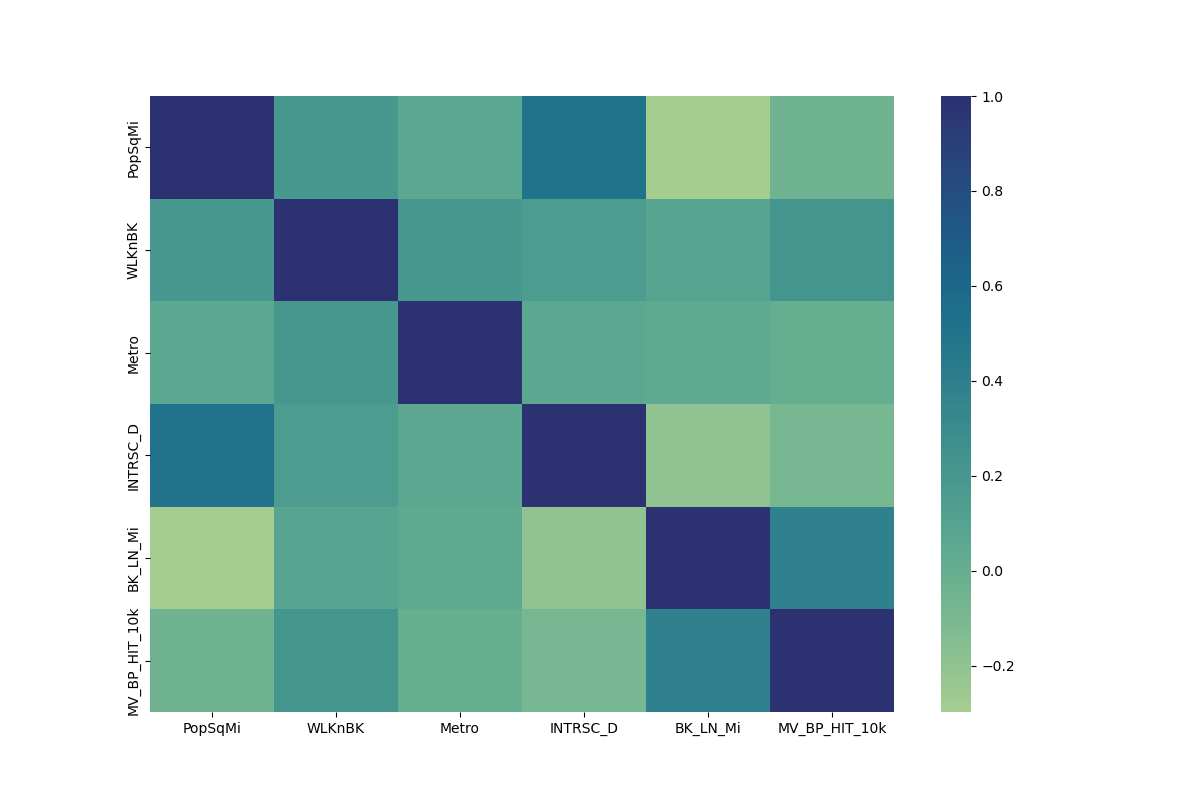

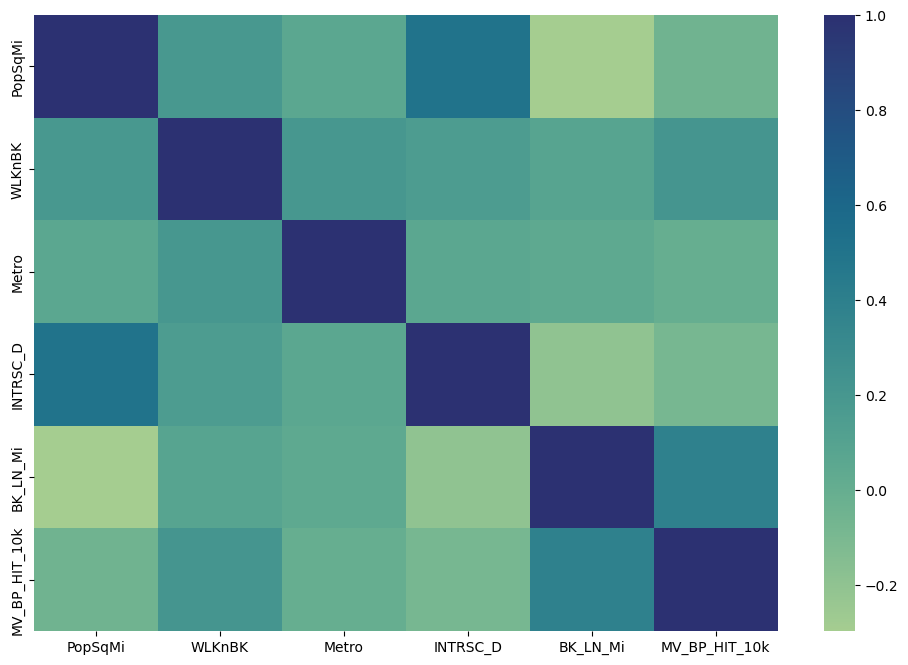

In [21]:
import tempfile
import base64

# Create correlation heatmap
plt.figure(figsize=(12,8)) 
sns.heatmap(clean_ti[ind_var].corr(), cmap="crest")

# Save the heatmap as a temporary PNG file
tempfile_path = tempfile.NamedTemporaryFile(suffix=".png").name
plt.savefig(tempfile_path)

# Read the PNG image and encode it as base64
with open(tempfile_path, "rb") as file:
    image_data = file.read()
    encoded_image = base64.b64encode(image_data).decode("utf-8")

# Generate HTML code to display the image
html_content = f'<img src="data:image/png;base64,{encoded_image}">'

# Print the HTML source code
print(html_content)

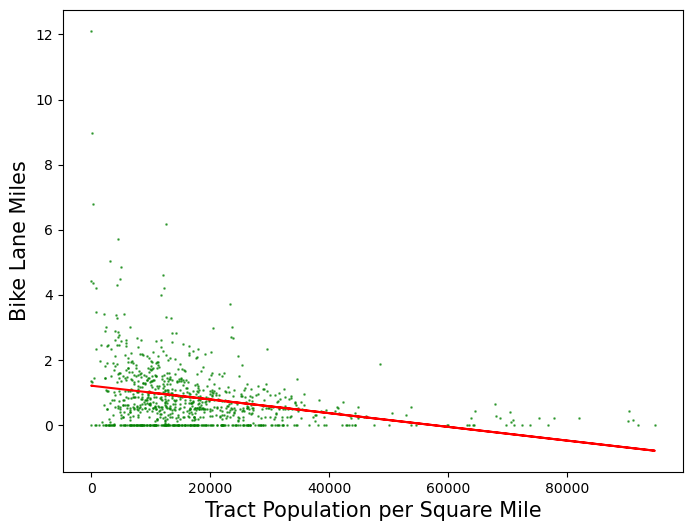

In [22]:
from matplotlib import pyplot as plt
# Scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
foo = ax.scatter(clean_ti['PopSqMi'], clean_ti['BK_LN_Mi'], c='g', alpha=0.6, s=0.8)
ax.set_xlabel("Tract Population per Square Mile", fontsize=15)
ax.set_ylabel('Bike Lane Miles', fontsize=15)

# Add best fit line
x = clean_ti['PopSqMi']
y = clean_ti['BK_LN_Mi']
m, b = np.polyfit(x, y, 1)  # Fit a first-degree polynomial (line) to the data
ax.plot(x, m*x + b, color='red')  # Plot the best fit line

plt.show()


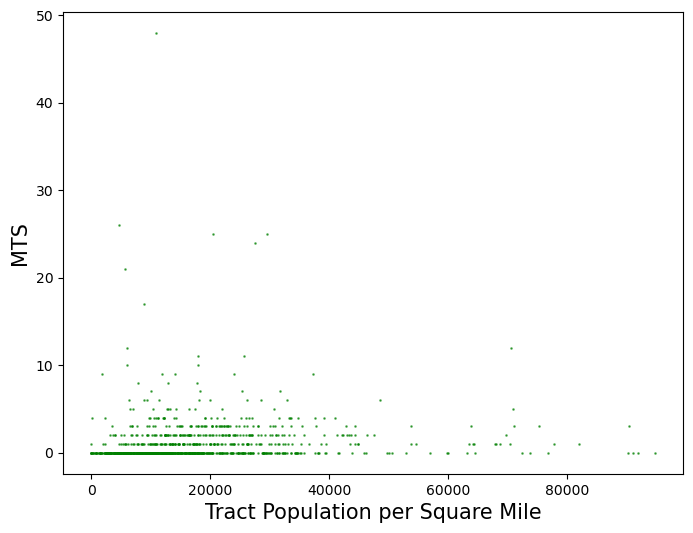

In [23]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
foo = ax.scatter(transpo_index['PopSqMi'], transpo_index['MTS'], c='g', alpha=0.6, s=0.8)
ax.set_xlabel("Tract Population per Square Mile", fontsize=15)
_ = ax.set_ylabel('MTS', fontsize=15)

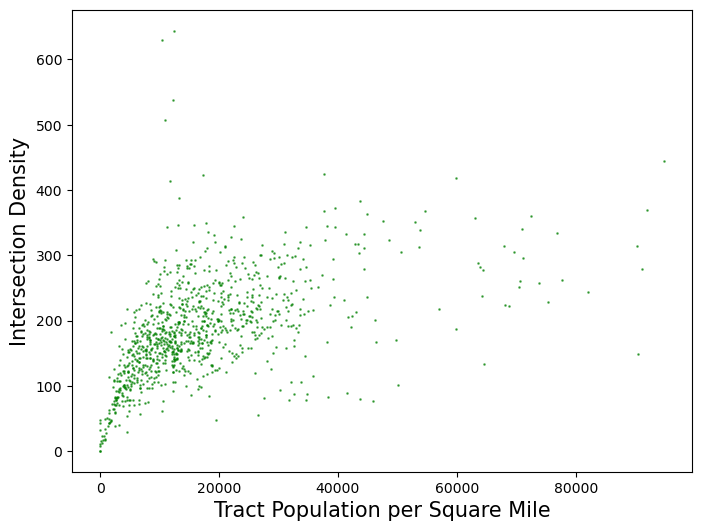

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
foo = ax.scatter(transpo_index['PopSqMi'], transpo_index['INTRSC_D'], c='g', alpha=0.6, s=0.8)
ax.set_xlabel("Tract Population per Square Mile", fontsize=15)
_ = ax.set_ylabel('Intersection Density', fontsize=15)

<Axes: >

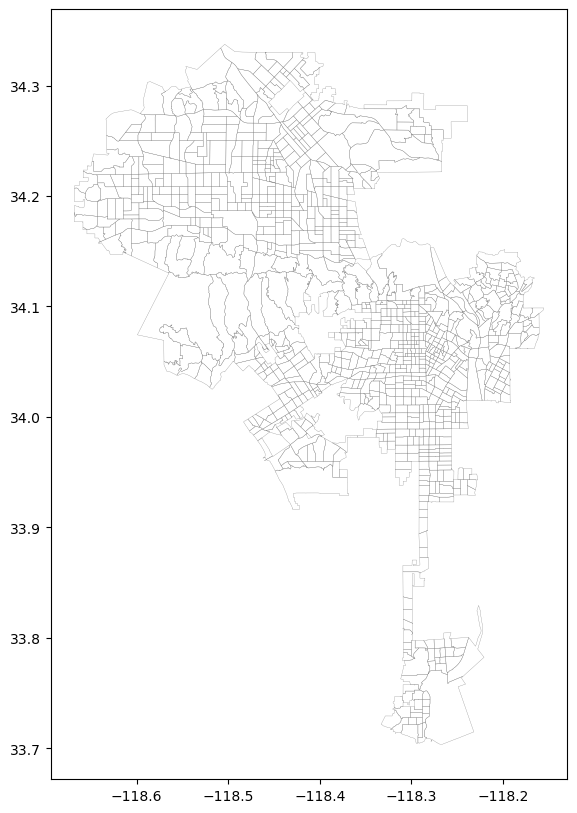

In [25]:
transpo_index.plot(color='none', edgecolor='gray', linewidth=.2, figsize=(14,10))

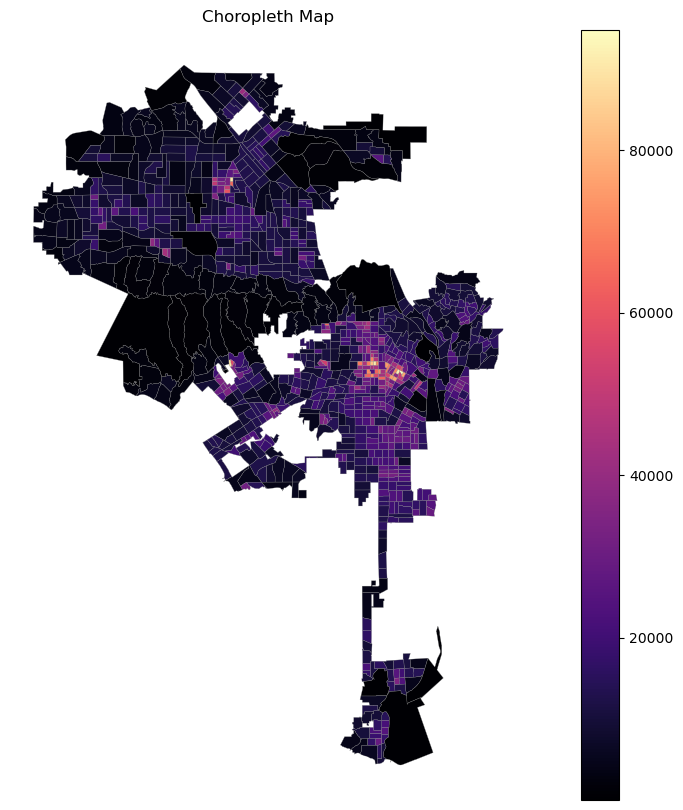

In [26]:
# Plot the choropleth map
fig, ax = plt.subplots(figsize=(14, 10))
transpo_index.plot(column='PopSqMi', cmap='magma', linewidth=0.2, ax=ax, edgecolor='gray', legend=True,)

# Customize the plot (add title, labels, etc.)
ax.set_title('Choropleth Map')
ax.set_axis_off()

# Show the map
plt.show()

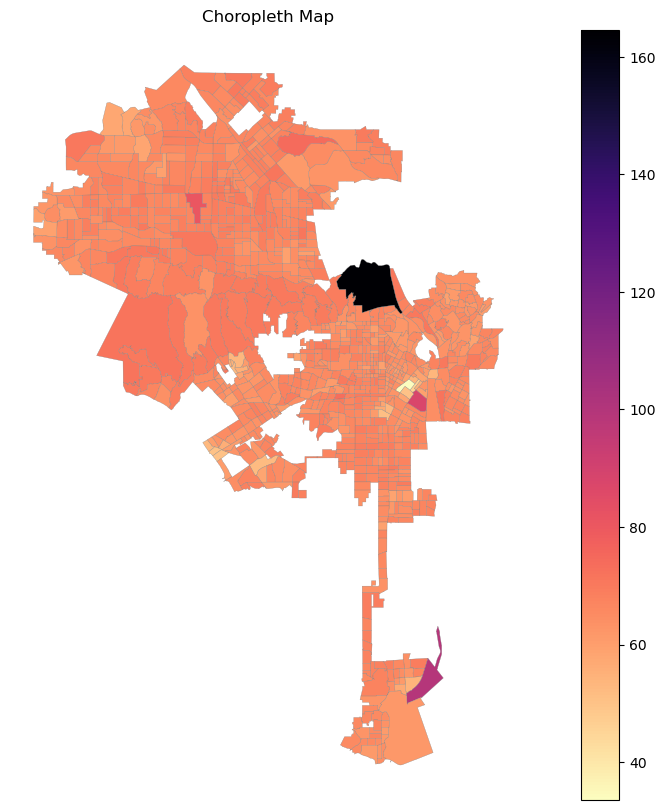

In [27]:
# Plot the choropleth map
fig, ax = plt.subplots(figsize=(14, 10))
transpo_index.plot(column='INDEX_SCORE', cmap='magma_r', linewidth=0.2, ax=ax, edgecolor='gray', legend=True,)

# Customize the plot (add title, labels, etc.)
ax.set_title('Choropleth Map')
ax.set_axis_off()

# Show the map
plt.show()

In [28]:
#locate huge outlier
high = transpo_index['INDEX_SCORE'].dropna().quantile(.99)
print(high)
#clean_ti_hit_10k = transpo_index.drop(transpo_index[transpo_index['MV_BP_HIT_10k'] == 146000].index)

71.22623432985736


In [29]:
clean_ti_index = transpo_index[(transpo_index['INDEX_SCORE'] < high)].copy()



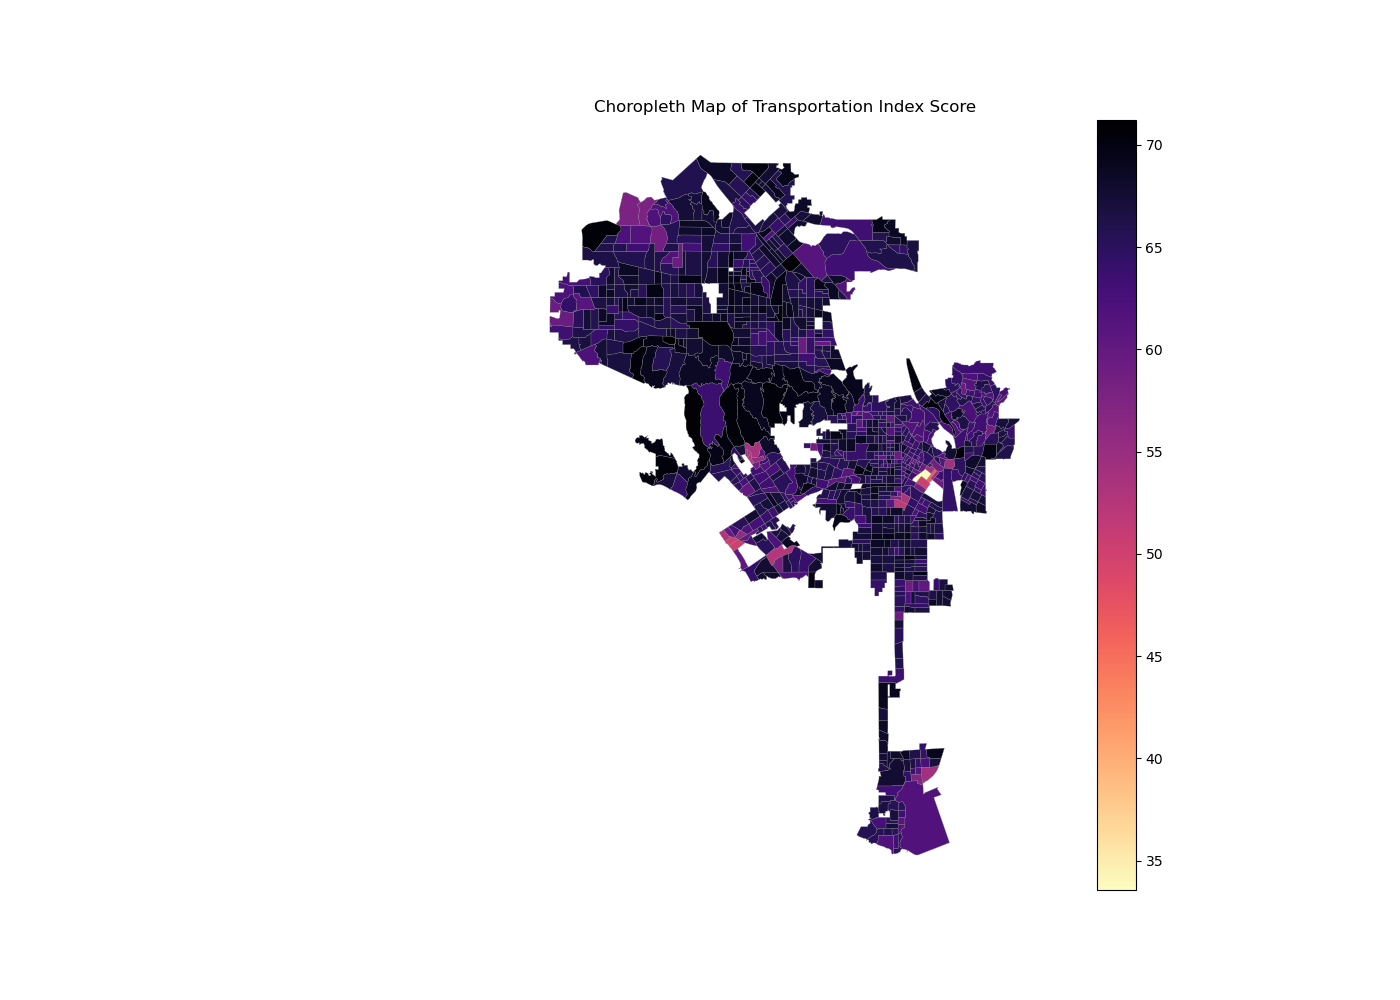

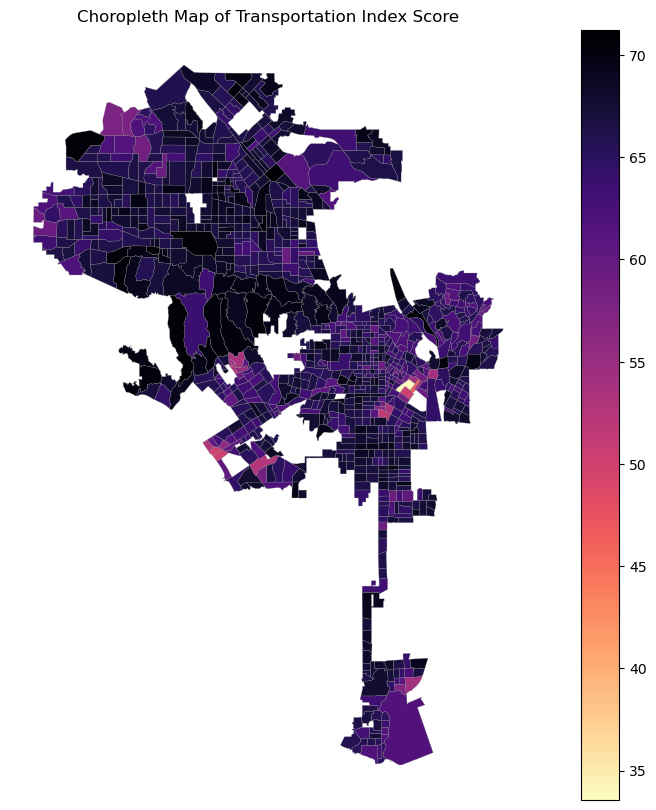

In [65]:
# Plot the choropleth map
fig, ax = plt.subplots(figsize=(14, 10))
clean_ti_index.plot(column='INDEX_SCORE', cmap='magma_r', linewidth=0.2, ax=ax, edgecolor='gray', legend=True)

# Customize the plot (add title, labels, etc.)
ax.set_title('Choropleth Map of Transportation Index Score')
ax.set_axis_off()

# Save the plot as a temporary PNG file
tempfile_path = tempfile.NamedTemporaryFile(suffix=".png").name
plt.savefig(tempfile_path)

# Read the PNG image and encode it as base64
with open(tempfile_path, "rb") as file:
    image_data = file.read()
    encoded_image = base64.b64encode(image_data).decode("utf-8")

# Generate HTML code to display the image
html_content = f'<img src="data:image/png;base64,{encoded_image}">'

# Print the HTML source code
print(html_content)

#still some large outliers

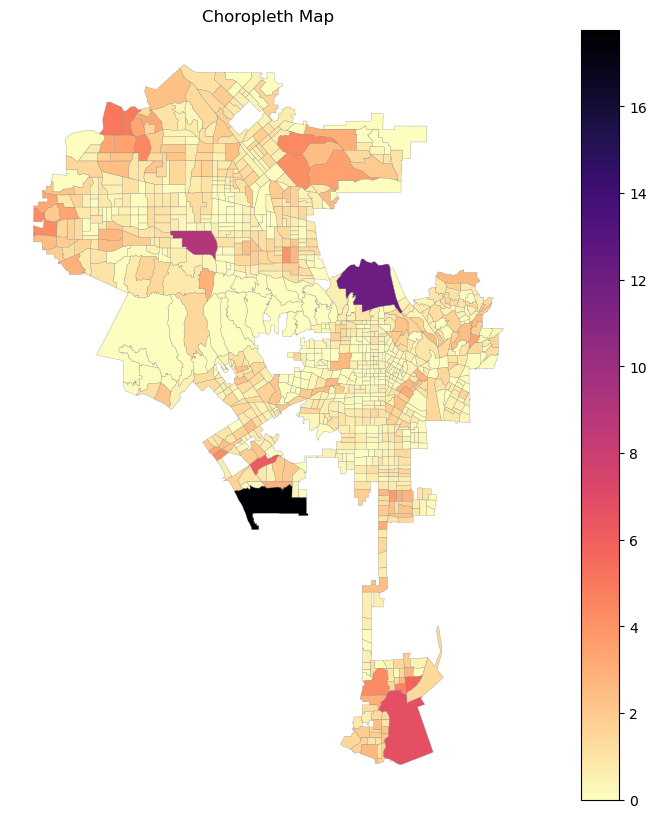

In [31]:
# Plot the choropleth map
fig, ax = plt.subplots(figsize=(14, 10))
transpo_index.plot(column='BK_LN_Mi', cmap='magma_r', linewidth=0.2, ax=ax, edgecolor='gray', legend=True,)

# Customize the plot (add title, labels, etc.)
ax.set_title('Choropleth Map')
ax.set_axis_off()

# Show the map
plt.show()

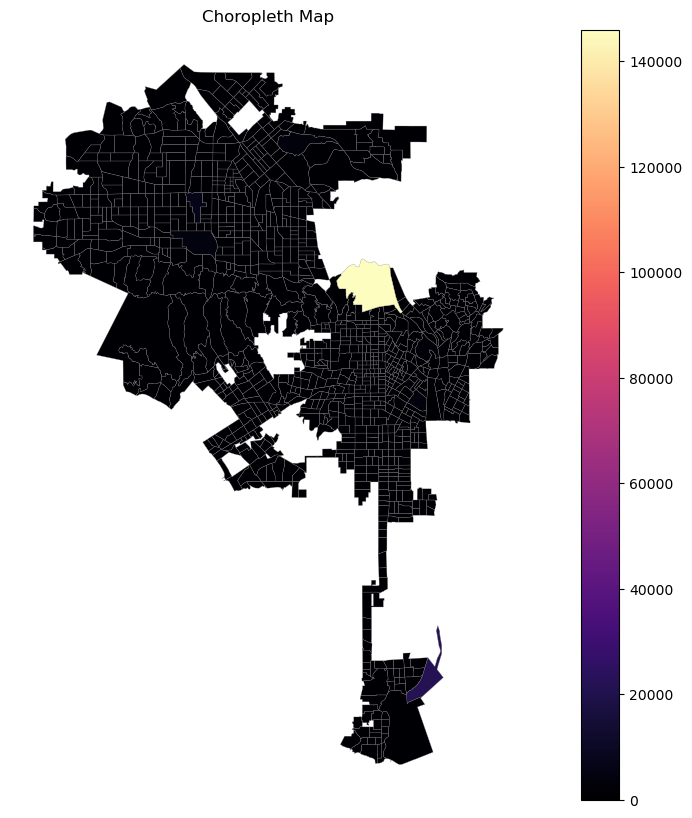

In [32]:
# Plot the choropleth map
fig, ax = plt.subplots(figsize=(14, 10))
transpo_index.plot(column='MV_BP_HIT_10k', cmap='magma', linewidth=0.2, ax=ax, edgecolor='gray', legend=True,)

# Customize the plot (add title, labels, etc.)
ax.set_title('Choropleth Map')
ax.set_axis_off()

# Show the map
plt.show()

In [33]:
#locate huge outlier
high = transpo_index['MV_BP_HIT_10k'].dropna().quantile(.99)
print(high)
#clean_ti_hit_10k = transpo_index.drop(transpo_index[transpo_index['MV_BP_HIT_10k'] == 146000].index)

890.3912853645147


In [34]:
clean_ti_hit_10k = transpo_index[(transpo_index['MV_BP_HIT_10k'] < high)].copy()

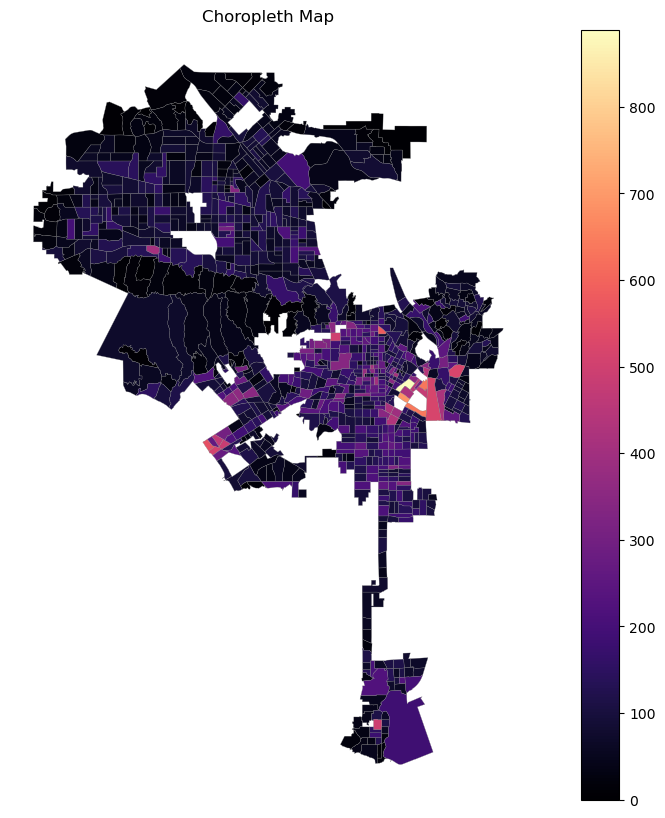

In [35]:
# Plot the choropleth map
fig, ax = plt.subplots(figsize=(14, 10))
clean_ti_hit_10k.plot(column='MV_BP_HIT_10k', cmap='magma', linewidth=0.2, ax=ax, edgecolor='gray', legend=True,)

# Customize the plot (add title, labels, etc.)
ax.set_title('Choropleth Map')
ax.set_axis_off()

# Show the map
plt.show()

#still some large outliers

In [36]:
laahp_endpoint_url = "https://data.lacity.org/resource/mymu-zi3s.json"
response = requests.get(laahp_endpoint_url)

In [37]:
results = response.text
print(type(results))
print(results[:500])

<class 'str'>
[{"apn":"5143020023","project_number":"02-118256","name":"SAN LUCAS APARTMENTS","development_stage":"In-Service","construction_type":"NEW CONSTRUCTION","address":"1221 W 7TH ST  Los Angeles, CA 90017","council_district":"1","site_cd":"1","community":"WESTLAKE","site_units":"196","project_total_units":"196","housing_type":"SENIORS","supportive_housing":"No","sh_units_per_site":"0","date_funded":"2001-11-29T00:00:00.000","hcidla_funded":"0","leverage":"0","tax_exempt_conduit_bond":"0","tdc":"0","i


In [38]:
laahp = pd.read_json(laahp_endpoint_url)
laahp.head()

,apn,project_number,name,development_stage,construction_type,address,council_district,site_cd,community,site_units,project_total_units,housing_type,supportive_housing,sh_units_per_site,date_funded,hcidla_funded,leverage,tax_exempt_conduit_bond,tdc,in_service_date,developer,management_company,contact_phone,photo,reporturl2,date_stamp,longitude,latitude,geocoded_column,:@computed_region_k96s_3jcv,:@computed_region_tatf_ua23,:@computed_region_ur2y_g4cx,:@computed_region_kqwf_mjcx,:@computed_region_2dna_qi2s,:@computed_region_qz3q_ghft,jobs,contract_numbers
0,5143020023,02-118256,SAN LUCAS APARTMENTS,In-Service,NEW CONSTRUCTION,"1221 W 7TH ST Los Angeles, CA 90017",1,1,WESTLAKE,196,196,SENIORS,No,0,2001-11-29T00:00:00.000,0.00,0.0,0,0.00,2003,N/A,GSL PROPERRTY MANAGEMENT,N/A,{'url': 'http://hcidapp.lacity.org/mpphotos/Im...,{'url': 'http://hcidapp.lacity.org/ahtfReportV...,2023-12-11T00:00:00.000,-118.26681,34.05209,"{'type': 'Point', 'coordinates': [-118.26681, ...",564,1047,54.0,11.0,76.0,23078,NaN,NaN
1,5502031011,14-121509,WILSHIRE TOWERS,In-Service,ACQUISITION + REHAB,"616 S NORMANDIE AVE Los Angeles, CA 90005",10,1,KOREATOWN,283,283,SENIORS,No,0,2015-03-12T00:00:00.000,0.00,52443992.0,0,52443992.00,2017,Thomas Safran & Associates Inc,THOMAS SAFRAN & ASSOCIATES,(310) 820-4888,{'url': 'http://hcidapp.lacity.org/mpphotos/Im...,{'url': 'http://hcidapp.lacity.org/ahtfReportV...,2023-12-11T00:00:00.000,-118.30016,34.06301,"{'type': 'Point', 'coordinates': [-118.30016, ...",598,1261,NaN,12.0,89.0,22722,NaN,NaN
2,5525004023,18-125504,POINTE ON LA BREA,In-Service,NEW CONSTRUCTION,"849 N LA BREA AVE LOS ANGELES, CA 90038",5,1,MELROSE,50,50,SPECIAL NEEDS,Yes,49,2021-11-03T00:00:00.000,7567686.00,22037233.0,4447000,34051919.00,2023,EAH Inc,EAH INC,(951) 966-1351,{'url': 'http://hcidapp.lacity.org/mpphotos/Im...,{'url': 'http://hcidapp.lacity.org/ahtfReportV...,2023-12-11T00:00:00.000,-118.34425,34.08646,"{'type': 'Point', 'coordinates': [-118.34425, ...",446,805,NaN,6.0,26.0,23677,218.0,C-139292
3,5050011005,05-117193,LEEWARD APTS. (SITE 7),In-Service,REHAB,"2809 S WEST BLVD Los Angeles, CA 90016",10,7,CRENSHAW DISTRICT,0,257,FAMILY,No,0,2005-05-02T00:00:00.000,0.00,7103994.0,10208936,17312930.00,2006,"HAMPSTEAD PARTNERS, INC.","ALPHA PROPERTY MANAGEMENT, INC.",(323) 231-4174,{'url': 'http://hcidapp.lacity.org/mpphotos/Im...,{'url': 'http://hcidapp.lacity.org/ahtfReportV...,2023-12-11T00:00:00.000,-118.34182,34.03071,"{'type': 'Point', 'coordinates': [-118.34182, ...",668,925,7.0,12.0,17.0,23077,NaN,NaN
4,5114014020,14-121652,FLORENCE MILLS (SITE 5),In-Service,NEW CONSTRUCTION,"1037 E MARTIN LUTHER KING BLVD LOS ANGELES, C...",9,5,CENTRAL,0,74,SPECIAL NEEDS,Yes,0,2018-12-17T00:00:00.000,9389115.63,36081992.0,0,45471107.63,2021,Hollywood Community Housing Corporation,BARKER MANAGEMENT INCORPORATED,(714) 533-3450,{'url': 'http://hcidapp.lacity.org/mpphotos/Im...,{'url': 'http://hcidapp.lacity.org/ahtfReportV...,2023-12-11T00:00:00.000,-118.25748,34.01115,"{'type': 'Point', 'coordinates': [-118.25748, ...",712,892,7.0,13.0,6.0,22727,226.0,C-129358


In [39]:
laahp.describe()

,apn,council_district,site_cd,site_units,project_total_units,sh_units_per_site,hcidla_funded,leverage,tax_exempt_conduit_bond,tdc,longitude,latitude,:@computed_region_k96s_3jcv,:@computed_region_tatf_ua23,:@computed_region_ur2y_g4cx,:@computed_region_kqwf_mjcx,:@computed_region_2dna_qi2s,:@computed_region_qz3q_ghft,jobs
count,5.700000e+02,570.000000,570.000000,570.000000,570.000000,570.000000,5.700000e+02,5.700000e+02,5.700000e+02,5.700000e+02,570.000000,570.000000,570.000000,570.000000,258.000000,566.000000,545.000000,570.000000,415.000000
mean,4.932518e+09,8.382456,2.094737,54.670175,91.361404,19.103509,4.077049e+06,1.622198e+07,3.021390e+06,2.332042e+07,-118.307726,34.054744,581.412281,840.717544,12.821705,10.053004,43.928440,21863.577193,193.453012
std,1.146126e+09,4.674394,2.809376,49.029599,66.258528,30.954383,4.327394e+06,1.288361e+07,9.896369e+06,1.743079e+07,0.075735,0.092147,258.018651,326.068436,13.434058,3.639608,26.231163,4322.753642,146.352206
min,2.103009e+09,1.000000,1.000000,0.000000,6.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-118.606390,33.736140,6.000000,98.000000,1.000000,1.000000,1.000000,3221.000000,5.000000
25%,5.046754e+09,5.250000,1.000000,21.000000,49.000000,0.000000,0.000000e+00,7.315242e+06,0.000000e+00,1.306244e+07,-118.320503,34.013325,447.500000,555.000000,7.000000,8.000000,19.000000,22721.250000,84.500000
50%,5.142518e+09,9.000000,1.000000,49.000000,72.000000,0.000000,3.007332e+06,1.331726e+07,0.000000e+00,1.868208e+07,-118.285480,34.047935,570.000000,898.000000,7.000000,11.000000,45.000000,23078.000000,174.000000
75%,5.502020e+09,13.000000,1.000000,75.000000,102.750000,36.000000,6.328587e+06,2.236827e+07,4.375750e+06,2.962620e+07,-118.263375,34.086415,729.000000,1047.000000,10.000000,13.000000,67.000000,23668.000000,261.500000
max,7.455014e+09,15.000000,20.000000,438.000000,438.000000,262.000000,2.480000e+07,9.407772e+07,1.842604e+08,2.230181e+08,-118.165250,34.324020,2330.000000,1521.000000,54.000000,15.000000,95.000000,26327.000000,1165.000000


In [40]:
!pip install censusgeocode

  Obtaining dependency information for requests[security]<3,>=2.27.0 from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/62.6 kB ? eta -:--:--
   ---------------------------------------- 62.6/62.6 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.
census-geocoder 0.1.0 requires requests==2.26.0, but you have requests 2.31.0 which is incompatible.
conda-repo-cli 1.0.41 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.41 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.
conda-repo-cli 1.0.41 requires requests==2.28.1, but you have requests 2.31.0 which is incompatible.


In [41]:
from shapely import Point

laahp['project_geom'] = laahp.apply(lambda x: Point(x["longitude"], x["latitude"]), axis=1)

import censusgeocode as cg

result = cg.coordinates(x=-76, y=41)

def get_census_tract(lat, lon):
    # Perform geocoding to get census tract information
    result = cg.coordinates(x=lon, y=lat)
    
    # Check if the result is not empty and has a valid format
    if result and isinstance(result, list) and result[0]:
        # Extract census tract information from the result if available
        if 'Census Tracts' in result[0]:
            census_tract = result[0]['Census Tracts'][0]['TRACT']
            return census_tract
    return None


# Assuming your DataFrame is called df and latitude and longitude columns are named 'latitude' and 'longitude'
#laahp['TRACT'] = laahp.apply(lambda row: get_census_tract(row['latitude'], row['longitude']), axis=1)


#laahp.head()

<Axes: >

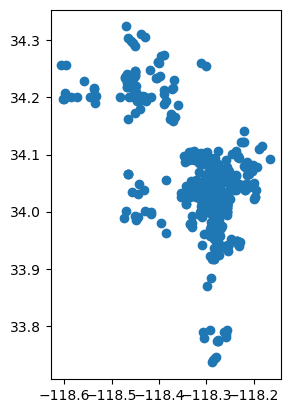

In [42]:
laahp_gdf = gpd.GeoDataFrame(laahp, geometry="project_geom", crs="epsg:4326")
laahp_gdf.plot()


In [43]:
laahp_gdf.head()

,apn,project_number,name,development_stage,construction_type,address,council_district,site_cd,community,site_units,project_total_units,housing_type,supportive_housing,sh_units_per_site,date_funded,hcidla_funded,leverage,tax_exempt_conduit_bond,tdc,in_service_date,developer,management_company,contact_phone,photo,reporturl2,date_stamp,longitude,latitude,geocoded_column,:@computed_region_k96s_3jcv,:@computed_region_tatf_ua23,:@computed_region_ur2y_g4cx,:@computed_region_kqwf_mjcx,:@computed_region_2dna_qi2s,:@computed_region_qz3q_ghft,jobs,contract_numbers,project_geom
0,5143020023,02-118256,SAN LUCAS APARTMENTS,In-Service,NEW CONSTRUCTION,"1221 W 7TH ST Los Angeles, CA 90017",1,1,WESTLAKE,196,196,SENIORS,No,0,2001-11-29T00:00:00.000,0.00,0.0,0,0.00,2003,N/A,GSL PROPERRTY MANAGEMENT,N/A,{'url': 'http://hcidapp.lacity.org/mpphotos/Im...,{'url': 'http://hcidapp.lacity.org/ahtfReportV...,2023-12-11T00:00:00.000,-118.26681,34.05209,"{'type': 'Point', 'coordinates': [-118.26681, ...",564,1047,54.0,11.0,76.0,23078,NaN,NaN,POINT (-118.26681 34.05209)
1,5502031011,14-121509,WILSHIRE TOWERS,In-Service,ACQUISITION + REHAB,"616 S NORMANDIE AVE Los Angeles, CA 90005",10,1,KOREATOWN,283,283,SENIORS,No,0,2015-03-12T00:00:00.000,0.00,52443992.0,0,52443992.00,2017,Thomas Safran & Associates Inc,THOMAS SAFRAN & ASSOCIATES,(310) 820-4888,{'url': 'http://hcidapp.lacity.org/mpphotos/Im...,{'url': 'http://hcidapp.lacity.org/ahtfReportV...,2023-12-11T00:00:00.000,-118.30016,34.06301,"{'type': 'Point', 'coordinates': [-118.30016, ...",598,1261,NaN,12.0,89.0,22722,NaN,NaN,POINT (-118.30016 34.06301)
2,5525004023,18-125504,POINTE ON LA BREA,In-Service,NEW CONSTRUCTION,"849 N LA BREA AVE LOS ANGELES, CA 90038",5,1,MELROSE,50,50,SPECIAL NEEDS,Yes,49,2021-11-03T00:00:00.000,7567686.00,22037233.0,4447000,34051919.00,2023,EAH Inc,EAH INC,(951) 966-1351,{'url': 'http://hcidapp.lacity.org/mpphotos/Im...,{'url': 'http://hcidapp.lacity.org/ahtfReportV...,2023-12-11T00:00:00.000,-118.34425,34.08646,"{'type': 'Point', 'coordinates': [-118.34425, ...",446,805,NaN,6.0,26.0,23677,218.0,C-139292,POINT (-118.34425 34.08646)
3,5050011005,05-117193,LEEWARD APTS. (SITE 7),In-Service,REHAB,"2809 S WEST BLVD Los Angeles, CA 90016",10,7,CRENSHAW DISTRICT,0,257,FAMILY,No,0,2005-05-02T00:00:00.000,0.00,7103994.0,10208936,17312930.00,2006,"HAMPSTEAD PARTNERS, INC.","ALPHA PROPERTY MANAGEMENT, INC.",(323) 231-4174,{'url': 'http://hcidapp.lacity.org/mpphotos/Im...,{'url': 'http://hcidapp.lacity.org/ahtfReportV...,2023-12-11T00:00:00.000,-118.34182,34.03071,"{'type': 'Point', 'coordinates': [-118.34182, ...",668,925,7.0,12.0,17.0,23077,NaN,NaN,POINT (-118.34182 34.03071)
4,5114014020,14-121652,FLORENCE MILLS (SITE 5),In-Service,NEW CONSTRUCTION,"1037 E MARTIN LUTHER KING BLVD LOS ANGELES, C...",9,5,CENTRAL,0,74,SPECIAL NEEDS,Yes,0,2018-12-17T00:00:00.000,9389115.63,36081992.0,0,45471107.63,2021,Hollywood Community Housing Corporation,BARKER MANAGEMENT INCORPORATED,(714) 533-3450,{'url': 'http://hcidapp.lacity.org/mpphotos/Im...,{'url': 'http://hcidapp.lacity.org/ahtfReportV...,2023-12-11T00:00:00.000,-118.25748,34.01115,"{'type': 'Point', 'coordinates': [-118.25748, ...",712,892,7.0,13.0,6.0,22727,226.0,C-129358,POINT (-118.25748 34.01115)


In [44]:
laahp.columns

Index(['apn', 'project_number', 'name', 'development_stage',
       'construction_type', 'address', 'council_district', 'site_cd',
       'community', 'site_units', 'project_total_units', 'housing_type',
       'supportive_housing', 'sh_units_per_site', 'date_funded',
       'hcidla_funded', 'leverage', 'tax_exempt_conduit_bond', 'tdc',
       'in_service_date', 'developer', 'management_company', 'contact_phone',
       'photo', 'reporturl2', 'date_stamp', 'longitude', 'latitude',
       'geocoded_column', ':@computed_region_k96s_3jcv',
       ':@computed_region_tatf_ua23', ':@computed_region_ur2y_g4cx',
       ':@computed_region_kqwf_mjcx', ':@computed_region_2dna_qi2s',
       ':@computed_region_qz3q_ghft', 'jobs', 'contract_numbers',
       'project_geom'],
      dtype='object')

In [45]:
#review sites with 0 units, group by community, group by council district

In [46]:
cleaned_laahp = laahp[laahp['project_total_units'] > 1]
cleaned_laahp.describe()

,apn,council_district,site_cd,site_units,project_total_units,sh_units_per_site,hcidla_funded,leverage,tax_exempt_conduit_bond,tdc,longitude,latitude,:@computed_region_k96s_3jcv,:@computed_region_tatf_ua23,:@computed_region_ur2y_g4cx,:@computed_region_kqwf_mjcx,:@computed_region_2dna_qi2s,:@computed_region_qz3q_ghft,jobs
count,5.700000e+02,570.000000,570.000000,570.000000,570.000000,570.000000,5.700000e+02,5.700000e+02,5.700000e+02,5.700000e+02,570.000000,570.000000,570.000000,570.000000,258.000000,566.000000,545.000000,570.000000,415.000000
mean,4.932518e+09,8.382456,2.094737,54.670175,91.361404,19.103509,4.077049e+06,1.622198e+07,3.021390e+06,2.332042e+07,-118.307726,34.054744,581.412281,840.717544,12.821705,10.053004,43.928440,21863.577193,193.453012
std,1.146126e+09,4.674394,2.809376,49.029599,66.258528,30.954383,4.327394e+06,1.288361e+07,9.896369e+06,1.743079e+07,0.075735,0.092147,258.018651,326.068436,13.434058,3.639608,26.231163,4322.753642,146.352206
min,2.103009e+09,1.000000,1.000000,0.000000,6.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-118.606390,33.736140,6.000000,98.000000,1.000000,1.000000,1.000000,3221.000000,5.000000
25%,5.046754e+09,5.250000,1.000000,21.000000,49.000000,0.000000,0.000000e+00,7.315242e+06,0.000000e+00,1.306244e+07,-118.320503,34.013325,447.500000,555.000000,7.000000,8.000000,19.000000,22721.250000,84.500000
50%,5.142518e+09,9.000000,1.000000,49.000000,72.000000,0.000000,3.007332e+06,1.331726e+07,0.000000e+00,1.868208e+07,-118.285480,34.047935,570.000000,898.000000,7.000000,11.000000,45.000000,23078.000000,174.000000
75%,5.502020e+09,13.000000,1.000000,75.000000,102.750000,36.000000,6.328587e+06,2.236827e+07,4.375750e+06,2.962620e+07,-118.263375,34.086415,729.000000,1047.000000,10.000000,13.000000,67.000000,23668.000000,261.500000
max,7.455014e+09,15.000000,20.000000,438.000000,438.000000,262.000000,2.480000e+07,9.407772e+07,1.842604e+08,2.230181e+08,-118.165250,34.324020,2330.000000,1521.000000,54.000000,15.000000,95.000000,26327.000000,1165.000000




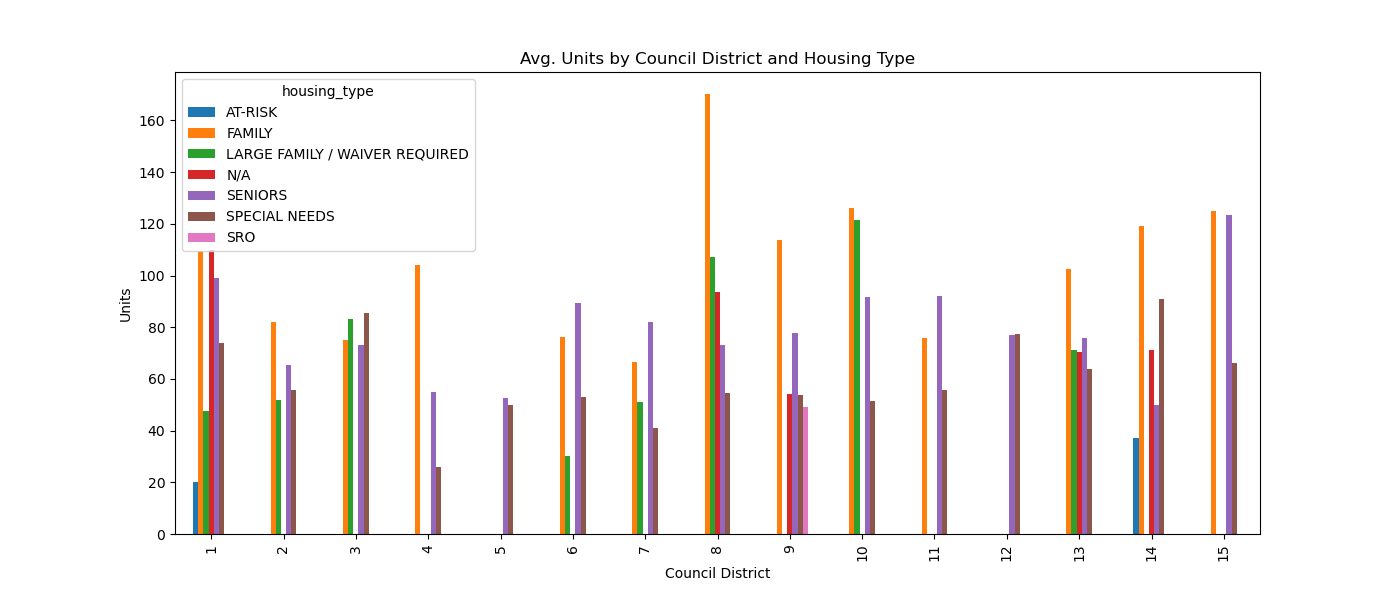

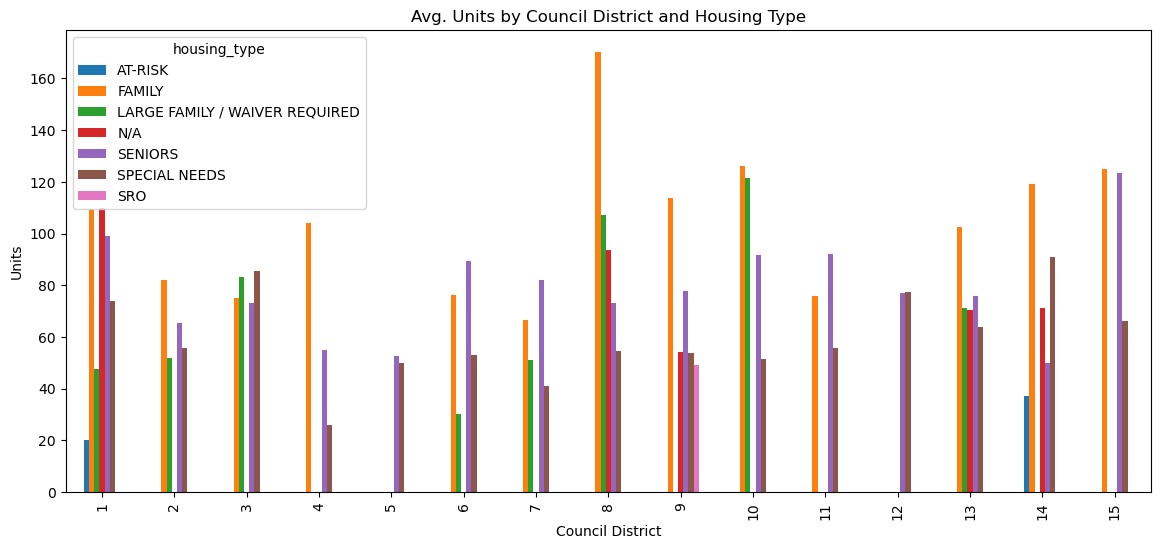

In [70]:
# Assuming laahp is your DataFrame
laahp_grouped = laahp.groupby(['council_district', 'housing_type'])['project_total_units'].mean().unstack()

# Plot the grouped data
ax = laahp_grouped.plot(kind='bar', figsize=(14, 6), title='Avg. Units by Council District and Housing Type', ylabel='Units', xlabel='Council District')

# Save the plot as a temporary file
tempfile_path = tempfile.NamedTemporaryFile(suffix=".png").name
plt.savefig(tempfile_path)

# Read the image and encode it as base64
with open(tempfile_path, "rb") as file:
    image_content = file.read()
    encoded_image = base64.b64encode(image_content).decode("utf-8")

# Generate HTML code to embed the image
html_code = f'<img src="data:image/png;base64,{encoded_image}" alt="Avg. Units by Council District and Housing Type">'

# Print the HTML source code
print(html_code)

In [48]:
ht_totals = laahp[['housing_type', 'project_total_units']].groupby('housing_type').sum()
ht_totals

,project_total_units
housing_type,
AT-RISK,57
FAMILY,28764
LARGE FAMILY / WAIVER REQUIRED,1775
N/A,1439
SENIORS,7639
SPECIAL NEEDS,12353
SRO,49


In [49]:
print(laahp[['project_total_units']].sum())

project_total_units    52076
dtype: int64




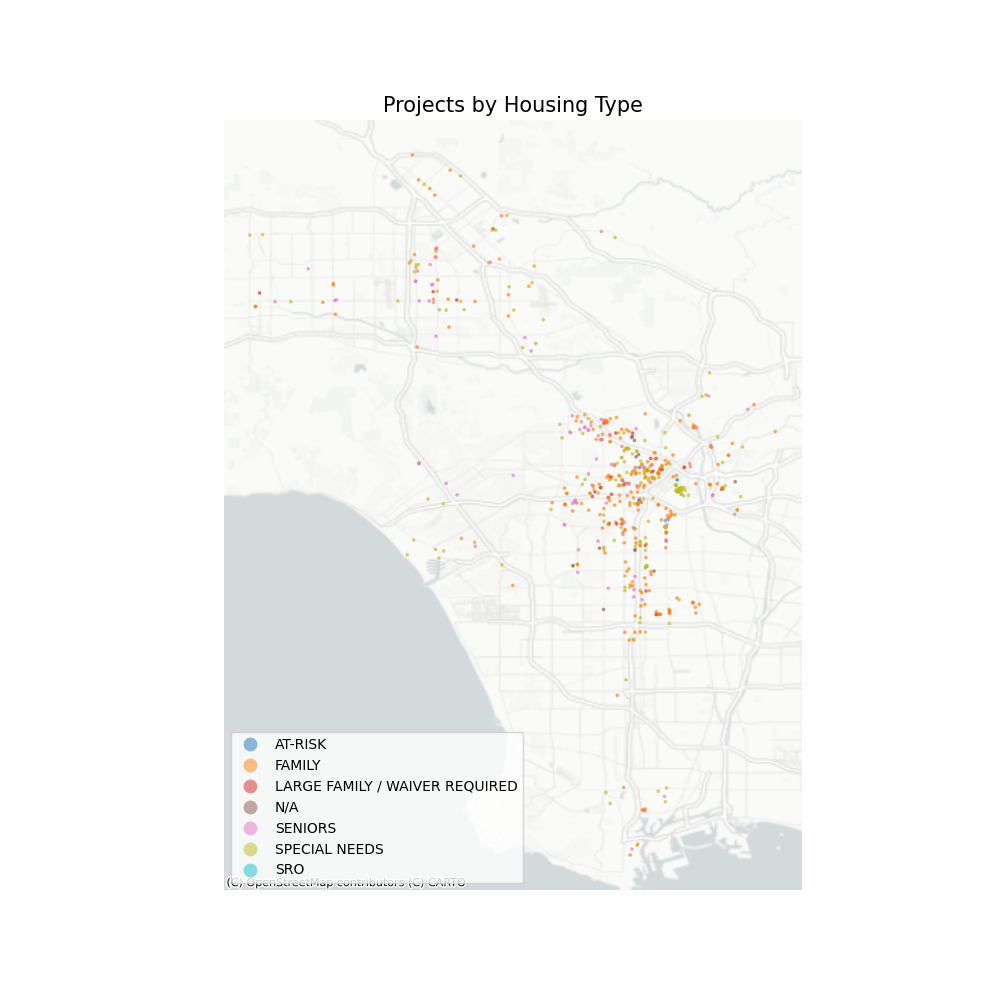

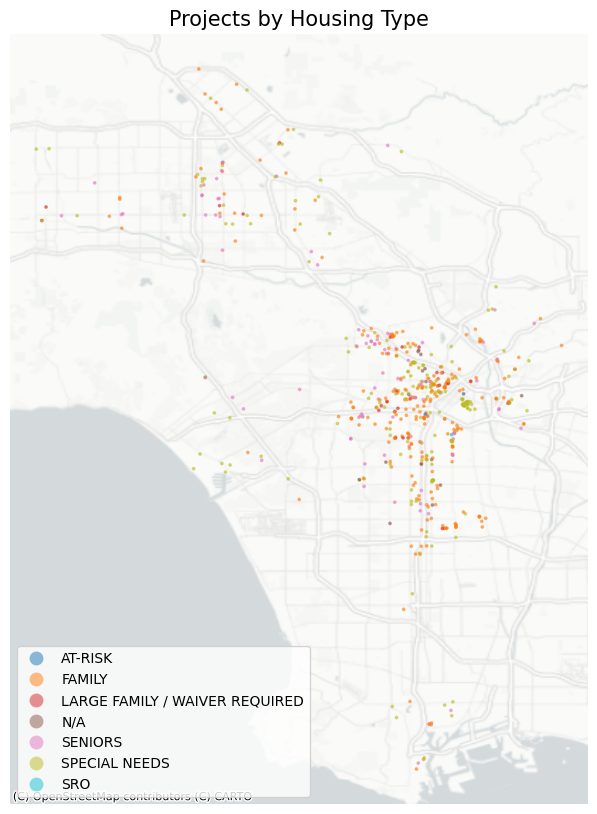

In [71]:
# Assuming laahp_gdf is your GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
laahp_gdf.plot(column='housing_type', markersize=3, ax=ax, alpha=0.5, legend=True)
ax.axis('off')
ax.set_title("Projects by Housing Type", fontsize=15)

# Add basemap
cx.add_basemap(
    ax,
    crs=laahp_gdf.crs.to_string(),
    source=cx.providers.CartoDB.PositronNoLabels,
    zoom=10
)

# Save the plot as a temporary file
tempfile_path = tempfile.NamedTemporaryFile(suffix=".png").name
plt.savefig(tempfile_path)

# Read the image and encode it as base64
with open(tempfile_path, "rb") as file:
    image_content = file.read()
    encoded_image = base64.b64encode(image_content).decode("utf-8")

# Generate HTML code to embed the image
html_code = f'<img src="data:image/png;base64,{encoded_image}" alt="Projects by Housing Type">'

# Print the HTML source code
print(html_code)

In [51]:
#laahp_gjson = laahp_gdf.to_json()
#laahp_gjson

In [52]:
#gpd.read_file(laahp_gjson).head()

In [53]:
laahp_geo = df_to_geojson(
    laahp, 
    properties=['address','community', 'project_total_units', 'housing_type'], 
    lat='latitude', 
    lon='longitude', 
    precision=4)

In [90]:
laahp['text'] = laahp['address']+' '+laahp['community']+' '+laahp['project_total_units'].astype(str)+' '+laahp['housing_type']
limits = [(0,50),(51,100),(101,150),(151, 200),(201,250),(251,800)]
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey","yellow"]

cities = []
scale = 100

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    laahp_sub = laahp[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = laahp_sub['longitude'],
        lat = laahp_sub['latitude'],
        text = laahp_sub['text'],
        marker = dict(
            size = laahp['project_total_units'],
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area',
            
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = '2014 US city populations<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

In [104]:
laahp_endpoint_url = "https://data.lacity.org/resource/mymu-zi3s.json"
response = requests.get(laahp_endpoint_url)
laahp = pd.read_json(laahp_endpoint_url)

laahp_geo = df_to_geojson(
    laahp, 
    properties=['address','community', 'project_total_units', 'housing_type'], 
    lat='latitude', 
    lon='longitude', 
    precision=4)

# Assign color stops
category_color_stops = [['AT-RISK', 'rgb(211,47,47)'],
                        ['FAMILY', 'rgb(81,45,168)'],
                        ['LARGE FAMILY / WAIVER REQUIRED', 'rgb(2,136,209)'],
                        ['N/A', 'rgb(139,195,74)'],
                        ['SENIORS', 'rgb(255,160,0)'],
                        ['SPECIAL NEEDS', 'rgb(122,189,0)'],
                        ['SRO', 'rgb(54,100,33)']]

# Radius stops for linear interpolation
sample_radius_stops = [[0.0, 1.0],
                       [50.0, 2.0],
                       [100.0, 3.0],
                       [150.0, 4.0],
                       [200.0, 5.0],
                       [250.0, 6.0]]

# Create the viz
viz1 = GraduatedCircleViz(
    laahp_geo,
    access_token=token,
    height='400px',
    color_property='housing_type',
    color_default='grey',
    color_function_type='match',
    color_stops=category_color_stops,
    radius_property='project_total_units', 
    radius_stops=sample_radius_stops,
    radius_function_type='interpolate', 
    radius_default=2,
    stroke_color='black',
    stroke_width=0.5,
    center=(-118.335, 34.02),
    zoom=8.5,
    opacity=0.75,
    below_layer='waterway-label',
    legend_layout='vertical',
    legend_function='color',
)


# Create HTML
html_output = viz1.create_html()

# Save or display HTML
with open('map_visualization.html', 'w') as f:
    f.write(html_output)


In [55]:
# Convert GeoDataFrame to GeoJSON
#ti_geo = gpd.GeoSeries(transpo_index.geometry).__geo_interface__

# Create a new GeoDataFrame with desired columns
ti_subset = transpo_index[['TRACT', 'INDEX_SCORE', 'PopSqMi', 'MV_BP_HIT_10k', 'geometry']]

# Convert the subset GeoDataFrame to GeoJSON
ti_geojson = ti_subset.to_json()

# Optionally, you can specify other parameters such as filename, driver, etc.
# For example:
# ti_subset.to_json("output.geojson", driver="GeoJSON")


In [56]:
viz2 = ChoroplethViz(la_tindex_endpoint_url, 
                     access_token=token,
                     height='400px',
                     color_property='INDEX_SCORE',
                     color_stops=create_color_stops([0, 35, 50, 65, 80, 95, 110], colors='YlOrRd'),
                     color_function_type='interpolate',
                      popup_open_action='click',
                     line_stroke='--',
                     line_color='rgb(128,0,38)',
                     line_width=1,
                     line_opacity=0.9,
                     opacity=0.8,
                     center=(-118.335, 34.02),
                     zoom=8.5,
                     below_layer='waterway-label',
                     legend_layout='horizontal',
                     legend_key_shape='bar',
                     legend_key_borders_on=False)


viz2.show()


C:\Users\sandr\anaconda3\Lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [57]:
cd_totals = laahp[['council_district', 'project_total_units']].groupby('council_district').sum()
cd_totals

,project_total_units
council_district,
1,10068
2,1009
3,706
4,809
5,261
6,2230
7,1059
8,7942
9,6147


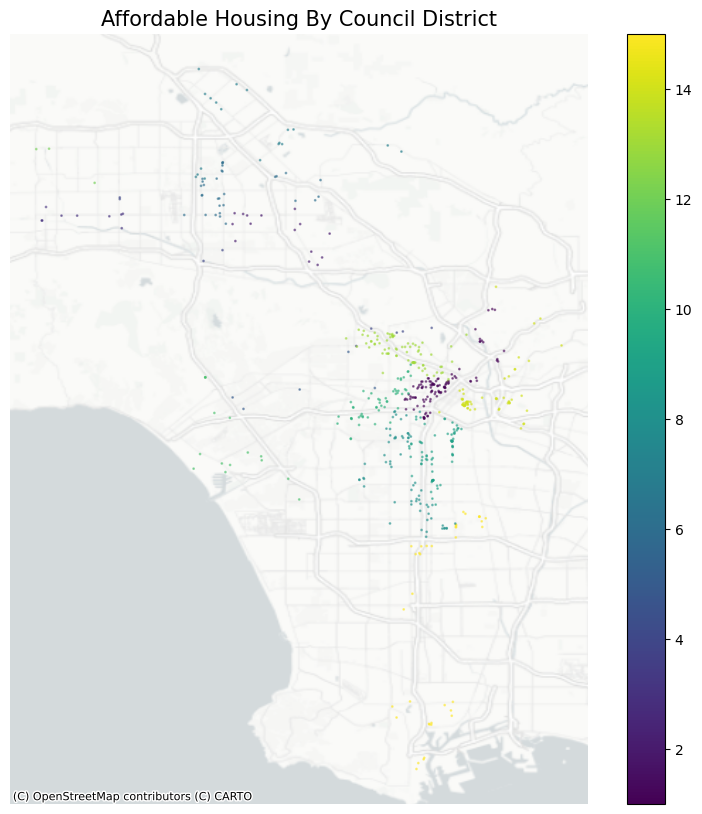

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
laahp_gdf.plot(column='council_district', markersize=1, ax=ax, alpha=0.5, legend=True)
ax.axis('off')
ax.set_title("Affordable Housing By Council District", fontsize=15)
cx.add_basemap(
    ax,
    crs=laahp_gdf.crs.to_string(),
    source=cx.providers.CartoDB.PositronNoLabels,
    zoom=10
)
plt.show()


In [59]:
nhbd_totals = laahp[['community', 'project_total_units']].groupby('community').sum()
nhbd_totals

,project_total_units
community,
ADAMS-NORMANDIE,328
ALSACE,251
ANGELINO HEIGHTS,33
ATWATER VILLAGE,347
BALDWIN HILLS,172
...,...
WESTLAKE,3746
WHOLESALE DISTRICT,2809
WILMINGTON,592


Analysis & Proposal

The data from the LA Transportation Index and the LA Affordable Housing Projects Pipeline both paint interesting pictures on the topics of transportation and land use. The opportunity and political will to prioritize affordable housing is noticable in the grouped projects by council district area. Council districts 1 and 8 have a huge pipeline of projects with a variety of housing types but council district 5 and 12 are not investing as much in affordable housing. The Transportation Index paints an interesting picture because of the large variance between census tracts in the city. Some areas of LA have very high and low population density leading to outliers in most of the value fields. I think the biggest hurdle will be deciding what data to remove.

Research Question: Are affordable housing projects being developed in transportation secure areas?

Plan:
Utilize the transportation index in addition to Transit and Vision Zero data to spatially compare the transportation security of affordable housing planned to be built in Los Angeles. The Affordable Housing Pipeline data is geocoded to a point location and the transportation index is geocoded to a census tract polygon. The transportation index is unfortunately not the most clear with its measures and a codebook is not shared. However some information is still easy to understand. I am seeking also tie in census data like commute and vehicle ownership. Through this project I want to learn how to integrate data from the GTFS feeds from LA Metro to also juxtapose the project's proximity to stations.

I am interested in combining multiple layers to compare to the census tract the housing project is situation in. Is there a way to geocode a point to an existing polygon in another layer?  By adding the census tract of each project it will be easier to merge the data sets to run regressions and measure the correlation of housing projects and the transportation characteristics of the neighborhood. 


In [60]:
import pandas as pd
import geopandas as gpd



In [61]:
rail_stops_df = pd.read_csv("https://gitlab.com/LACMTA/gtfs_rail/raw/master/stops.txt?inline=false", delimiter=",")
rail_stops_df.shape

from shapely import Point

rail_stops_df['stop_geom'] = rail_stops_df.apply(lambda x: Point(x["stop_lon"], x["stop_lat"]), axis=1)

rail_stops_df.head()


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,stop_url,location_type,parent_station,tpis_name,stop_geom
0,80101,80101,Downtown Long Beach Station,NaN,33.768071,-118.192921,NaN,0,80101S,Long Bch,POINT (-118.192921 33.768071)
1,80101S,80101S,Downtown Long Beach Station,NaN,33.768071,-118.192921,NaN,1,NaN,NaN,POINT (-118.192921 33.768071)
2,80101A,80101A,Downtown Long Beach Station - 1st & Pacific En...,NaN,33.768050,-118.193500,NaN,2,80101S,NaN,POINT (-118.1935 33.76805)
3,80101B,80101B,Downtown Long Beach Station - 1st & Pine Entrance,NaN,33.768040,-118.192500,NaN,2,80101S,NaN,POINT (-118.1925 33.76804)
4,80102,80102,Pacific Ave Station,NaN,33.772258,-118.193700,NaN,0,80102S,Pacific,POINT (-118.1937 33.772258)


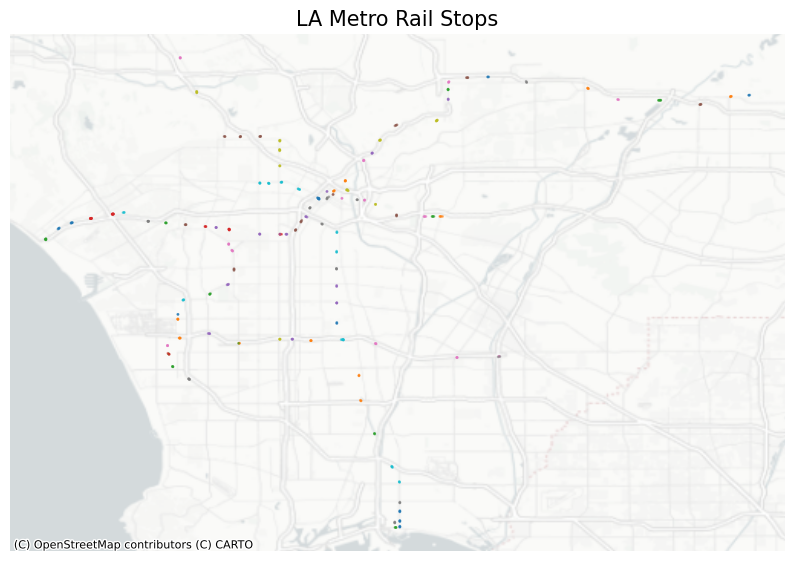

In [62]:
rail_stops_gdf = gpd.GeoDataFrame(rail_stops_df, geometry="stop_geom", crs="epsg:4326")

fig, ax = plt.subplots(figsize=(10,10))
rail_stops_gdf.plot(column='stop_name', markersize=1, ax=ax, alpha=0.5, legend=False)
ax.axis('off')
ax.set_title("LA Metro Rail Stops", fontsize=15)
cx.add_basemap(
    ax,
    crs=rail_stops_gdf.crs.to_string(),
    source=cx.providers.CartoDB.PositronNoLabels,
    zoom=10
)

plt.show()

In [63]:
bus_stops_df = pd.read_csv(r"C:\Users\sandr\UCB_CYPLAN255_2024\assignments\assignment_4\data\metro_bus\stops.txt", delimiter=",")

bus_stops_df.shape

from shapely import Point

bus_stops_df['stop_geom'] = bus_stops_df.apply(lambda x: Point(x["stop_lon"], x["stop_lat"]), axis=1)

bus_stops_df.head()


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,stop_url,location_type,parent_station,tpis_name,stop_geom
0,1,1,Paramount / Slauson,NaN,33.973248,-118.113113,NaN,NaN,NaN,NaN,POINT (-118.113113 33.973248)
1,3,3,Jefferson / 10th,NaN,34.025471,-118.328402,NaN,NaN,NaN,NaN,POINT (-118.328402 34.025471)
2,6,6,120th / Augustus F Hawkins,NaN,33.924696,-118.242222,NaN,NaN,NaN,NaN,POINT (-118.242222 33.924696)
3,7,7,120th / Martin Luther King Hospital,NaN,33.924505,-118.240369,NaN,NaN,NaN,NaN,POINT (-118.240369 33.924505)
4,12,12,15054 Sherman Way,NaN,34.201075,-118.461953,NaN,NaN,NaN,NaN,POINT (-118.461953 34.201075)


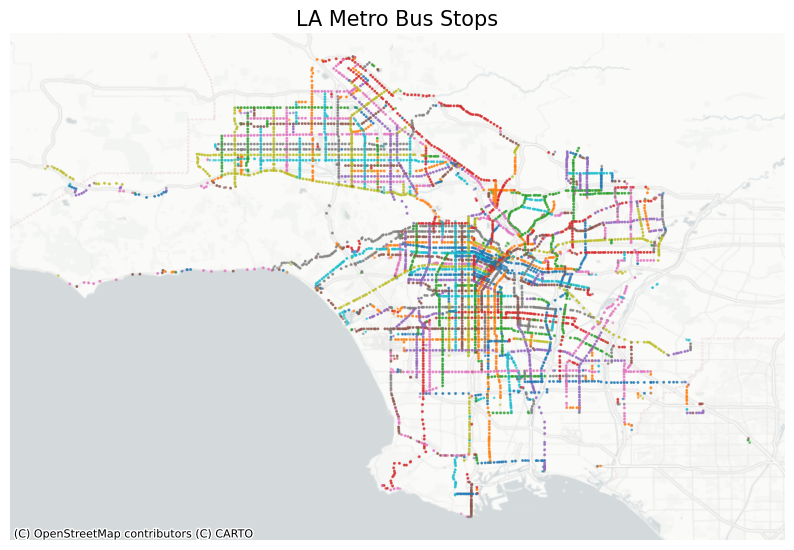

In [64]:
bus_stops_gdf = gpd.GeoDataFrame(bus_stops_df, geometry="stop_geom", crs="epsg:4326")

fig, ax = plt.subplots(figsize=(10,10))
bus_stops_gdf.plot(column='stop_name', markersize=1, ax=ax, alpha=0.5, legend=False)
ax.axis('off')
ax.set_title("LA Metro Bus Stops", fontsize=15)
cx.add_basemap(
    ax,
    crs=bus_stops_gdf.crs.to_string(),
    source=cx.providers.CartoDB.PositronNoLabels,
    zoom=10
)

plt.show()